<a href="https://colab.research.google.com/github/da-on-git/recognize_speech_command/blob/main/TrainEvalMvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train and Evaluate a Minimal Viable Model (MVM)

Load audio files into runtime disk space

In [1]:
%%time
%pip install wget
import wget
url = 'https://lp-prod-resources.s3.us-west-2.amazonaws.com/234/google_speech_new.zip'
fname = wget.download(url)
!unzip -q $fname -d /content/
import os
os.remove(fname) #Remove downloaded zip file
import shutil
shutil.rmtree('/content/__MACOSX') #Remov Mac specific files
# For compatibility with the csv file name
os.rename('/content/google_speech/validation', '/content/google_speech/validate')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=73d07f818ee8baabdf4dde9d56bb616a87dfa22b57781dec72e7f58f4cbd485e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
CPU times: user 4.38 s, sys: 4.19 s, total: 8.57 s
Wall time: 2min 3s


Set path variables for building the mel-spectrogram data files

In [2]:
from pathlib import Path
current_dir = Path('.')
data_path = current_dir / 'google_speech'
spectograms_path = current_dir / 'spectograms'


Remove all spectogram files

In [3]:
import shutil
shutil.rmtree (spectograms_path, ignore_errors=True)

A function to pad audio clips with zero to have a uniform length

In [4]:
import numpy as np
def pad_audio_with_silence(audio: np.ndarray, target_n_samples: int):
    assert audio.shape[0] <= target_n_samples, f"Audio is larger than {target_n_samples}"
    padded_audio = np.zeros(target_n_samples)
    padded_audio[:audio.shape[0]] = audio
    return padded_audio

A function to create one mel-spectogram file

In [5]:
n_samples = 16000
n_fft = 2048
hop_length = n_fft // 4
n_mels = 128

import librosa as lb
import numpy as np
import os
from tensorflow import keras
from keras import utils

def save_mel(file_path):
    wav_path = Path(file_path)
    mel_path = wav_path.with_suffix('.png')
    if os.path.isfile(audio_path / wav_path):
        y, sr = lb.load(audio_path / wav_path, sr=None)
        y = pad_audio_with_silence(y,n_samples)
        S = lb.feature.melspectrogram(y=y, sr=sr,  n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = lb.power_to_db(S, ref=np.max)
        assert S_dB.shape[1] == 32, f"mel size is not 32"
        utils.save_img(spec_path / mel_path, np.expand_dims(S_dB, axis=2),
              data_format=None, file_format=None, scale=True)
        return S_dB.shape
    else:
        print("File not found: ", wav_path)
        return (0,0)


Select a split to generate,
Read the split csv file and extract labels,
Make directories for the split,
Generate spectograms for a split

In [6]:
%%time

import pandas as pd
import os

splits = ['train', 'test', 'validate']
scale_down_factor = 20

for split in splits:
    audio_path = data_path / split / 'audio'
    spec_path = spectograms_path / split
    split_csv_path = data_path / split / f"{split}.csv"

    split_csv_df= pd.read_csv(split_csv_path)
    labels = split_csv_df['label'].unique()
    split_len = split_csv_df.shape[0]
    apply_len = split_len // scale_down_factor

    print(f"{split}: {apply_len} out of {split_len}")

    for category in (labels):
      os.makedirs(spec_path / category)

    apply_df = split_csv_df.sample(n=apply_len).copy()
    result = apply_df['file_path'].apply(save_mel)

train: 2554 out of 51088
test: 341 out of 6835
validate: 339 out of 6798
File not found:  no/794cdfc5_nohash_1.wav
File not found:  no/3bdf05d3_nohash_0.wav
CPU times: user 38.3 s, sys: 19.6 s, total: 57.9 s
Wall time: 41.2 s


Convert a disk folder with subfolders and files into an list of paths

In [7]:
from pathlib import Path

def list_file_paths(root):
    root_path = Path(root)
    all_files = [file for file in root_path.rglob("*") if file.is_file()]
    return all_files


In [8]:
# Example usage:
file_paths = list_file_paths(spectograms_path)
print(file_paths)

[PosixPath('spectograms/validate/eight/c6ee87a7_nohash_0.png'), PosixPath('spectograms/validate/eight/db9d52d2_nohash_0.png'), PosixPath('spectograms/validate/eight/6c0f6493_nohash_1.png'), PosixPath('spectograms/validate/eight/9d32f10a_nohash_1.png'), PosixPath('spectograms/validate/eight/e14a99a5_nohash_0.png'), PosixPath('spectograms/validate/eight/a7dd45cf_nohash_0.png'), PosixPath('spectograms/validate/eight/4abefdf5_nohash_0.png'), PosixPath('spectograms/validate/eight/750e3e75_nohash_0.png'), PosixPath('spectograms/validate/eight/439c84f4_nohash_2.png'), PosixPath('spectograms/validate/eight/53d5b86f_nohash_0.png'), PosixPath('spectograms/validate/eight/471a0925_nohash_4.png'), PosixPath('spectograms/validate/eight/bdee441c_nohash_0.png'), PosixPath('spectograms/validate/eight/7117fb6d_nohash_0.png'), PosixPath('spectograms/validate/eight/962f27eb_nohash_0.png'), PosixPath('spectograms/validate/eight/ad63d93c_nohash_3.png'), PosixPath('spectograms/validate/seven/e14a99a5_nohash_

Randomly select one file path of the list of file paths

In [9]:
import random

random_file_path = random.choice(file_paths)
print(random_file_path)


spectograms/train/down/f0ac2522_nohash_0.png


Display the selected spectogram image file.

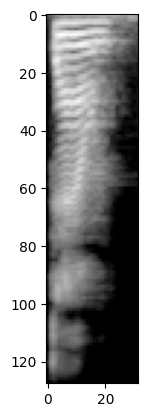

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
# Load image from file
img = Image.open(random_file_path)
# Display an image
plt.imshow(img, cmap='gray')

Build Keras Dataset for preprocessing

In [11]:
from tensorflow import keras
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(spectograms_path / "train",
labels="inferred",
color_mode="grayscale",
batch_size=32,
image_size=(128, 32),
shuffle=True,
seed=6825)

validate_dataset = image_dataset_from_directory(spectograms_path / "validate",
labels="inferred",
color_mode="grayscale",
batch_size=32,
image_size=(128, 32),
shuffle=True,
seed=6825)

test_dataset = image_dataset_from_directory(spectograms_path / "test",
labels="inferred",
color_mode="grayscale",
batch_size=32,
image_size=(128, 32),
shuffle=True,
seed=6825)

Found 2554 files belonging to 30 classes.
Found 337 files belonging to 30 classes.
Found 341 files belonging to 30 classes.


Displaying samples of training images

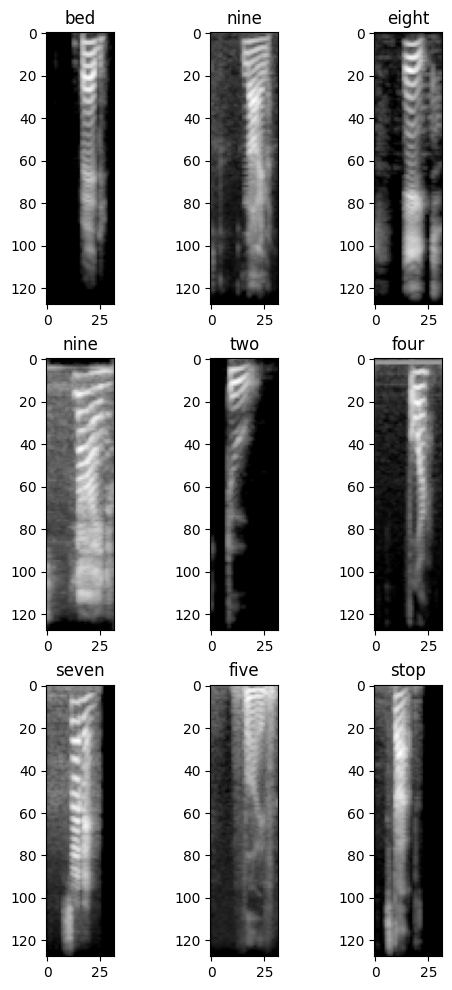

In [12]:
import matplotlib.pyplot as plt

words = train_dataset.class_names
fig, axs = plt.subplots(3, 3, figsize=(6, 12))
for images, labels in train_dataset.take(1):
    for ax, img in zip(axs.flat, range(9)):
      ax.imshow(images[img], cmap='gray')
      ax.set_title(words[labels[img]])
    # Add space between the rows
    plt.subplots_adjust(hspace=0.2)

Instantiating a small convnet

In [13]:
from tensorflow import keras
from keras import Input
from keras import Model
from keras import layers

words = train_dataset.class_names
print(len(words))
inputs = Input(shape=(128, 32, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(words), activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

30


Displaying the model's summary

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 126, 30, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 4, 128)        73856 

Training the convnet using the datasets

In [15]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [16]:
from keras.callbacks import ModelCheckpoint

saved_model_file = "convnet_from_scratch.keras.tf"  # Must use suffix .tf

callbacks = [
        ModelCheckpoint(
        filepath=saved_model_file,
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=12,
    validation_data=validate_dataset,
    callbacks=callbacks)

Epoch 1/12
80/80 [==============================] - 6s 26ms/step - loss: 6.5159 - accuracy: 0.0435 - val_loss: 3.3690 - val_accuracy: 0.0593
Epoch 2/12
80/80 [==============================] - 1s 9ms/step - loss: 3.5072 - accuracy: 0.0885 - val_loss: 3.5600 - val_accuracy: 0.0237
Epoch 3/12
80/80 [==============================] - 1s 17ms/step - loss: 3.2832 - accuracy: 0.1551 - val_loss: 3.0060 - val_accuracy: 0.1751
Epoch 4/12
80/80 [==============================] - 2s 23ms/step - loss: 2.5371 - accuracy: 0.3078 - val_loss: 2.7324 - val_accuracy: 0.2878
Epoch 5/12
80/80 [==============================] - 1s 16ms/step - loss: 1.8937 - accuracy: 0.4695 - val_loss: 2.9067 - val_accuracy: 0.3234
Epoch 6/12
80/80 [==============================] - 1s 9ms/step - loss: 1.4281 - accuracy: 0.5948 - val_loss: 2.7471 - val_accuracy: 0.4006
Epoch 7/12
80/80 [==============================] - 1s 10ms/step - loss: 0.9876 - accuracy: 0.7028 - val_loss: 2.9857 - val_accuracy: 0.3680
Epoch 8/12
80/8

Save the last model

In [17]:
model.save('last_model.keras.tf')

Displaying curves of loss and accuracy during training

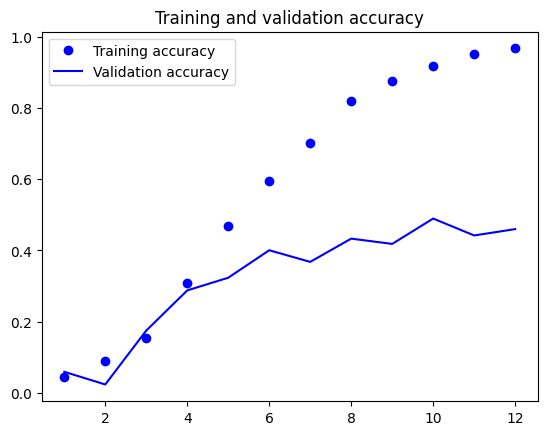

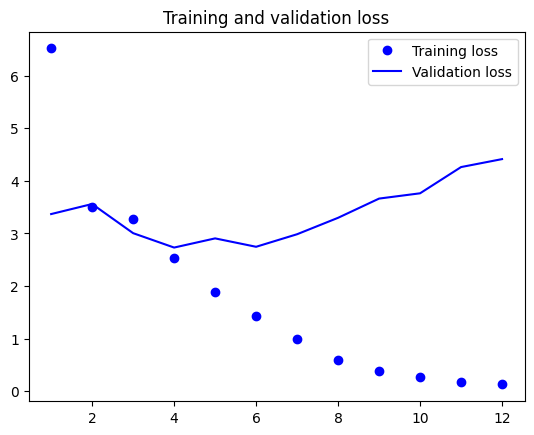

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load the best model for testing and save it also in HDF5 format.

In [19]:
test_model = keras.models.load_model(saved_model_file)
saved_model_file_hdf5 = "convnet_from_scratch.keras.h5"
model.save(saved_model_file_hdf5)
# Test loading HDF5 format
test_model_HDF5 = keras.models.load_model(saved_model_file_hdf5)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Permanently save the HDF5 model in google drive

In [20]:
from google.colab import drive
import shutil

drive.mount('/content/drive')
google_drive_path = Path('/content/drive/MyDrive/Colab Notebooks/RecSpeech')
shutil.copy(saved_model_file_hdf5, google_drive_path)

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/RecSpeech/convnet_from_scratch.keras.h5'

Evaluating the model accuracy on the test set

In [21]:
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

11/11 [==============================] - 0s 21ms/step - loss: 2.7817 - accuracy: 0.2786
Test accuracy: 0.279


Create lists of predictions and labels fore evaluating by various methods

In [22]:
import numpy as np
from sklearn.metrics import f1_score

i_true = [] # list of true labels
i_pred = [] # list of predictions

for batch in test_dataset:
    data, labels = batch
    y_pred = test_model.predict(data)
    # For each case in batch find the label with largest score
    ib_pred = np.argmax(y_pred, axis=1) # b stands for batch
    # Concatenate predictions of all batches
    i_pred.extend(ib_pred)
    # Concatenate true lables of all batches as well
    ib_true = labels.numpy().tolist()
    i_true.extend(ib_true)


1/1 [==============================] - 0s 104ms/step


Evaluating the best model using macro-averaged F1 score on the test set

In [23]:
# Calculate the macro-averaged F1 score
f1_macro = f1_score(i_true, i_pred, average='macro')
f1_macro

0.2545038701421122

Draw a confusion matrix

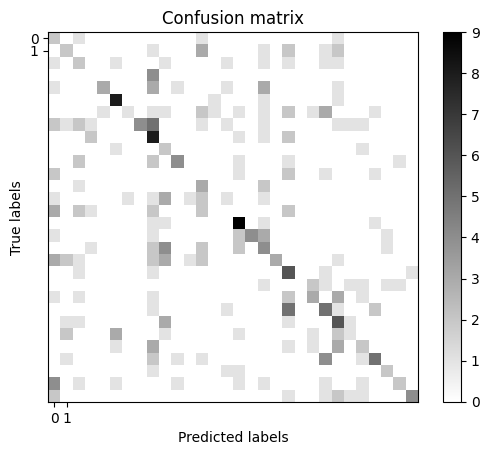

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(i_true, i_pred)

plt.imshow(cm, cmap='binary')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

Print tuples of (true_label, predicted_label) for first 30

In [25]:
compare = zip(i_true, i_pred)
for i,item in enumerate(compare):
    print(item)
    if i==30:
      break

(19, 29)
(10, 19)
(16, 15)
(25, 21)
(8, 8)
(29, 23)
(8, 19)
(8, 3)
(18, 8)
(23, 23)
(6, 9)
(7, 7)
(22, 22)
(4, 8)
(21, 25)
(12, 12)
(26, 26)
(22, 22)
(6, 13)
(3, 8)
(24, 21)
(15, 15)
(21, 21)
(6, 8)
(1, 19)
(20, 22)
(27, 14)
(29, 22)
(23, 23)
(18, 11)
(1, 1)


Compare performance to a dummy model that randomly guesses word labels according to their frequency in the dataset.

First, get the integer labels and their frequencies from the train Dataset.

In [26]:
import numpy as np

i_true_train = np.empty(0, dtype=int)

for batch in train_dataset:
    data, labels = batch
    ib_true = labels.numpy() # b stands for batch
    i_true_train = np.append(i_true_train,ib_true)

labels, counts = np.unique(i_true_train, return_counts=True)
normalized_counts = np.divide(counts, np.sum(counts))

print("Unique values:", labels)
print("Counts:", counts)
print("Normalized counts:", normalized_counts)
normalized_counts.shape

Unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Counts: [ 72  70  82  74  88  90  79  97 112  74  76  89  70  89  88  73 101 101
  97  95  59  97  85 105  67  83  86  74  88  93]
Normalized counts: [0.02819107 0.02740799 0.0321065  0.02897416 0.03445576 0.03523884
 0.03093187 0.03797964 0.04385278 0.02897416 0.02975724 0.0348473
 0.02740799 0.0348473  0.03445576 0.02858262 0.03954581 0.03954581
 0.03797964 0.03719655 0.02310102 0.03797964 0.03328113 0.04111198
 0.02623336 0.03249804 0.03367267 0.02897416 0.03445576 0.03641347]


(30,)

Create a random array of predictions for the test_dataset, the predictions has the same normalized counts

In [27]:
# Compute the number of repetitions, elements, for each label for the predictions.
N = len(i_true)
num_elements = np.floor(normalized_counts * N).astype(int)
# The total number of predictions must be the same as the size of the test dataset
diff = N - np.sum(num_elements)

# Add one repeat to the label with the largest error in its normalized count
while diff > 0:
    normalized_num_elements = np.divide(num_elements, N)
    errors = normalized_counts - normalized_num_elements
    print(num_elements,errors,diff)
    # Find index of largest error by sorting in decreasing order, by
    # negating the error value
    indices = np.argsort(-errors)
    num_elements[indices[0]] += 1
    diff = N - np.sum(num_elements)

normalized_num_elements = np.divide(num_elements, N)
errors = normalized_counts - normalized_num_elements
print(num_elements,errors,diff)

# Create the predictions array by repeating the integer label values
pred_normalized = np.repeat(labels, num_elements)

# Shuffle the predictions array to make it random
np.random.shuffle(pred_normalized)

[ 9  9 10  9 11 12 10 12 14  9 10 11  9 11 11  9 13 13 12 12  7 12 11 14
  8 11 11  9 11 12] [1.79811095e-03 1.01502559e-03 2.78098641e-03 2.58119631e-03
 2.19769116e-03 4.82251979e-05 1.60635838e-03 2.78902394e-03
 2.79706148e-03 2.58119631e-03 4.31730343e-04 2.58923384e-03
 1.01502559e-03 2.58923384e-03 2.19769116e-03 2.18965363e-03
 1.42264334e-03 1.42264334e-03 2.78902394e-03 2.00593859e-03
 2.57315877e-03 2.78902394e-03 1.02306313e-03 5.62627309e-05
 2.77294888e-03 2.39977770e-04 1.41460580e-03 2.58119631e-03
 2.19769116e-03 1.22285323e-03] 19
[ 9  9 10  9 11 12 10 12 15  9 10 11  9 11 11  9 13 13 12 12  7 12 11 14
  8 11 11  9 11 12] [ 1.79811095e-03  1.01502559e-03  2.78098641e-03  2.58119631e-03
  2.19769116e-03  4.82251979e-05  1.60635838e-03  2.78902394e-03
 -1.35489842e-04  2.58119631e-03  4.31730343e-04  2.58923384e-03
  1.01502559e-03  2.58923384e-03  2.19769116e-03  2.18965363e-03
  1.42264334e-03  1.42264334e-03  2.78902394e-03  2.00593859e-03
  2.57315877e-03  2.7890239

Evaluating the macro-averaged F1 score of Dummy normalized predictoron the test set

In [28]:
f1_macro = f1_score(i_true, pred_normalized, average='macro')
f1_macro

0.02053614525076849